In [109]:
import pandas as pd
import numpy as np
from numpy import array
import yfinance as yf
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
today = date.today()
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pykalman import KalmanFilter

1. **LSTM**

In [110]:
startDate = '2014-01-01'
endDate = today
 
# Fetching the data
StockData = yf.download('AIZ', start=startDate, end=endDate, progress=False)

In [111]:
def fitKCA(t,z,q):
    '''
    Inputs:
    t: Iterable with time indices
    z: Iterable with measurements
    q: Scalar that multiplies the seed states covariance

    Output:
    x[0]: smoothed state means of position velocity and acceleration
    x[1]: smoothed state covar of position velocity and acceleration
    Dependencies: numpy, pykalman
    '''
    #1) Set up matrices A,H and a seed for Q
    h=(t[-1]-t[0]).days/t.shape[0]
    A=np.array([[1,h,.5*h**2],
    [0,1,h],
    [0,0,1]])
    Q=q*np.eye(A.shape[0])
    #2) Apply the filter
    kf=KalmanFilter(transition_matrices=A,transition_covariance=Q)

    # Filtering
    state_means, state_covs = kf.filter(z)
    return state_means,state_covs

In [112]:
state_means,state_covs = fitKCA(StockData.index, StockData['Close'].values, 1)
kca = pd.DataFrame(state_means, index=StockData.index, columns=['position', 'velocity', 'acceleration']).iloc[1:]

In [113]:
rtn = StockData['Close'] / StockData['Close'].shift(1) - 1

data = pd.concat([kca, rtn.to_frame('daily_return')], axis = 1).dropna()
data

,position,velocity,acceleration,daily_return
Date,,,,
2014-01-03,59.931676,17.231929,6.090436,0.006124
2014-01-06,67.874053,8.963399,0.341753,0.006999
2014-01-07,67.626173,-0.581116,-2.986231,0.009671
2014-01-08,67.366851,-2.152415,-2.073359,0.011374
2014-01-09,68.040322,-0.728643,-0.609512,0.011838
...,...,...,...,...
2024-05-15,175.645884,-0.939637,-0.333673,-0.010489
2024-05-16,175.396842,-0.337330,0.025138,0.000057
2024-05-17,175.564234,0.166477,0.179496,0.000684


<Axes: xlabel='Date'>

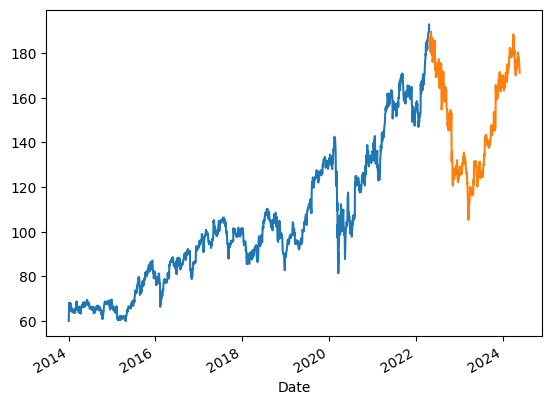

In [114]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['position', 'velocity', 'acceleration']], data[['daily_return']].shift(-1), test_size = 0.2, shuffle = False)
X_train['position'].plot()
X_test['position'].plot()

In [115]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
 
DataScaler_x = sc.fit(X_train)
X_train_std = DataScaler_x.transform(X_train)
X_test_std = DataScaler_x.transform(X_test)

DataScaler_y = sc.fit(y_train)
y_train_std = DataScaler_y.transform(y_train)
y_test_std = DataScaler_y.transform(y_test)

In [116]:
X_train_std

array([[-1.40320767, 13.40559177, 12.87340499],
       [-1.14063079,  6.95386016,  0.72178478],
       [-1.14882574, -0.49348991, -6.31293942],
       ...,
       [ 2.88106441, -0.12599668, -0.47765071],
       [ 2.99293564,  1.80610859,  1.47971447],
       [ 2.91976781, -1.0937071 , -1.8242506 ]])

In [117]:
TimeSteps=30  # next day's Price Prediction is based on last TimeSteps past day's prices
Features = X_train.shape[1]

In [118]:
def window_time_series(series, n, step = 1, label = False):
#    print "in window_time_series",series
    if step < 1.0:
        step = max(int(step * n), 1)
    if label == False:
        return [series[i:i+n] for i in range(0, len(series) - n + 1, step)]
    else:
        return [series[i:i+n][-1] for i in range(0, len(series) - n + 1, step)]

In [119]:
X_train_std_window = np.array(window_time_series(X_train_std, TimeSteps, step = 1))
X_test_std_window = np.array(window_time_series(X_test_std, TimeSteps, step = 1))

y_train_std_window = np.array(window_time_series(y_train_std, TimeSteps, step = 1, label = True))
y_test_std_window = np.array(window_time_series(y_test_std, TimeSteps, step = 1, label = True))

In [120]:
print(f"X shape = {X_train_std_window.shape}, y shape = {y_train_std_window.shape}")

X shape = (2061, 30, 3), y shape = (2061, 1)


In [121]:
# Initialising the LSTM
regressor = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, Features), return_sequences=True))
 
# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, Features), return_sequences=True))
 
# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
# Adding the output layer
regressor.add(Dense(units = 1))
  
# Compiling the LSTM choose either sgd or Adam
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

/Users/wei/anaconda3/envs/AdvancedRiskManagement/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [122]:
regressor.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 30, 10)         │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 30, 5)          │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 5)              │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,106 (4.32 KB)

 Trainable params: 1,106 (4.32 KB)

 Non-trainable params: 0 (0.00 B)

In [123]:
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
history = regressor.fit(X_train_std_window, y_train_std_window, validation_split=0.1, epochs=30, batch_size=60, verbose=1,shuffle=False)
 
EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.6844 - val_loss: 0.5643
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.6842 - val_loss: 0.5643
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6840 - val_loss: 0.5643
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6839 - val_loss: 0.5645
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6839 - val_loss: 0.5646
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6837 - val_loss: 0.5645
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7121 - val_loss: 0.5650
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6836 - val_loss: 0.5648
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6835 - val_loss: 0.5648
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6835 - val_loss: 0.5648
Epoch 11/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6835 - val_loss: 0.5649
Epoch 12/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6

In [124]:
def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])

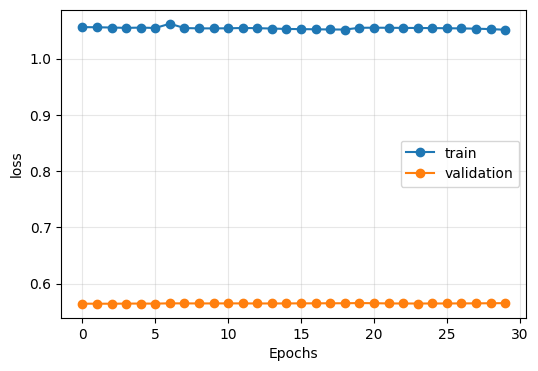

In [125]:
plt.figure(figsize=(6,4))
plot_train_history(history, 'loss','val_loss')
plt.grid(alpha = 0.3)

In [126]:
# Making predictions on test data
predicted_y = regressor.predict(X_test_std_window)
predicted_y = DataScaler_y.inverse_transform(predicted_y)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [127]:
predicted_y = pd.Series(predicted_y.reshape(-1), index = y_test.index[-len(predicted_y):])

<Axes: >

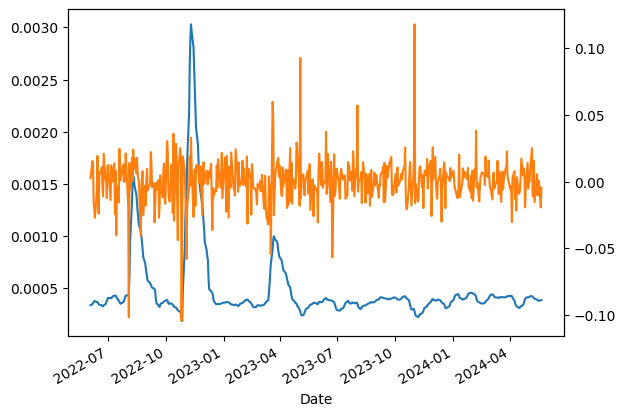

In [128]:
predicted_y.plot()
rtn.loc[predicted_y.index].plot(secondary_y = True)


<Axes: xlabel='Date'>

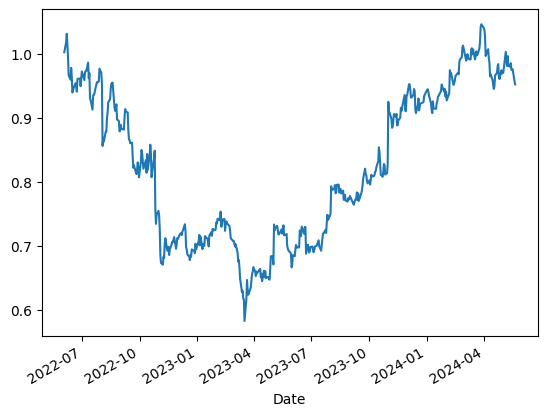

In [129]:
signal = (predicted_y > 0) * 2 - 1
(signal * rtn.loc[signal.index] + 1).cumprod().plot()

2. **Transform Model**

In [130]:
startDate = '2014-01-01'
endDate = today
 
# Fetching the data
StockData = yf.download('AWK', start=startDate, end=endDate, progress=False)

In [131]:
state_means,state_covs = fitKCA(StockData.index, StockData['Close'].values, 1)
kca = pd.DataFrame(state_means, index=StockData.index, columns=['position', 'velocity', 'acceleration']).iloc[1:]

In [132]:
rtn = StockData['Close'] / StockData['Close'].shift(1) - 1

data = pd.concat([kca, rtn.to_frame('daily_return')], axis = 1).dropna()
data

,position,velocity,acceleration,daily_return
Date,,,,
2014-01-03,37.840983,10.773864,3.807904,-0.002886
2014-01-06,42.389307,5.299848,0.111392,-0.003859
2014-01-07,42.184471,-0.447744,-1.847285,0.009927
2014-01-08,41.585887,-1.649544,-1.358567,-0.000240
2014-01-09,41.393708,-0.929029,-0.469548,-0.002398
...,...,...,...,...
2024-05-15,133.614346,0.311592,0.293634,0.004657
2024-05-16,134.275660,0.663660,0.269228,0.003888
2024-05-17,133.854609,-0.181866,-0.139038,-0.003798


<Axes: xlabel='Date'>

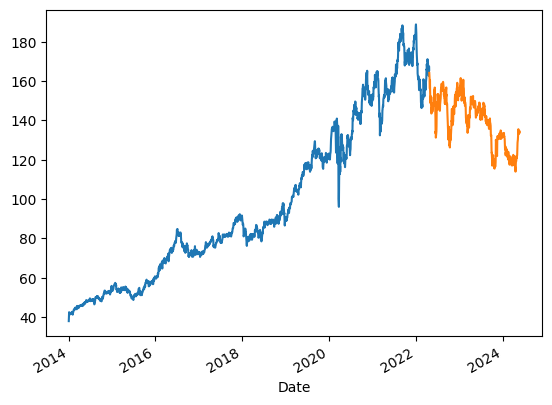

In [133]:
X_train, X_test, y_train, y_test = train_test_split(data[['position', 'velocity', 'acceleration']], data[['daily_return']].shift(-1), test_size = 0.2, shuffle = False)
X_train['position'].plot()
X_test['position'].plot()

In [134]:
sc=StandardScaler()
 
DataScaler_x = sc.fit(X_train)
X_train_std = DataScaler_x.transform(X_train)
X_test_std = DataScaler_x.transform(X_test)

DataScaler_y = sc.fit(y_train)
y_train_std = DataScaler_y.transform(y_train)
y_test_std = DataScaler_y.transform(y_test)

In [135]:
TimeSteps=30  # next day's Price Prediction is based on last TimeSteps past day's prices
Features = X_train.shape[1]

In [136]:
X_train_std_window = np.array(window_time_series(X_train_std, TimeSteps, step = 1))
X_test_std_window = np.array(window_time_series(X_test_std, TimeSteps, step = 1))

y_train_std_window = np.array(window_time_series(y_train_std, TimeSteps, step = 1, label = True))
y_test_std_window = np.array(window_time_series(y_test_std, TimeSteps, step = 1, label = True))

In [137]:
print(f"X shape = {X_train_std_window.shape}, y shape = {y_train_std_window.shape}")

X shape = (2061, 30, 3), y shape = (2061, 1)


In [138]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the transformer-like model
inputs = layers.Input(shape=(TimeSteps, Features))
x = layers.MultiHeadAttention(num_heads=4, key_dim=64)(inputs, inputs)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="linear")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the transformer-like model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mean_absolute_error",
)

# Train the model
history = model.fit(X_train_std_window, y_train_std_window, validation_split=0.1, epochs=30, batch_size=60, verbose=1,shuffle=False)

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.5796 - val_loss: 0.7325
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5696 - val_loss: 0.7301
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5695 - val_loss: 0.7304
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5694 - val_loss: 0.7402
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5692 - val_loss: 0.7349
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5695 - val_loss: 0.7489
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.5692 - val_loss: 0.7358
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.5691 - val_loss: 0.7426
Epoch 9/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5689 - val_loss: 0.7453
Epoch 10/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5689 - val_loss: 0.7446
Epoch 11/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.5689 - val_loss: 0.7469
Epoch 12/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5

In [139]:
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 30, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 3)     │      3,843 │ input_layer_7[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 3)         │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │        256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         65 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,494 (48.81 KB)

 Trainable params: 4,164 (16.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,330 (32.54 KB)

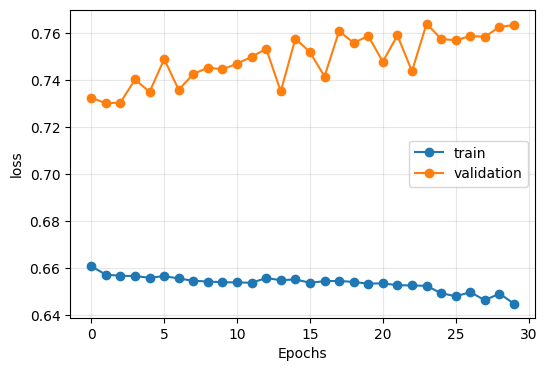

In [140]:
plt.figure(figsize=(6,4))
plot_train_history(history, 'loss','val_loss')
plt.grid(alpha = 0.3)

In [141]:
# Making predictions on test data
predicted_y = model.predict(X_test_std_window)
predicted_y = DataScaler_y.inverse_transform(predicted_y)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [142]:
predicted_y = pd.Series(predicted_y.reshape(-1), index = y_test.index[-len(predicted_y):])

<Axes: >

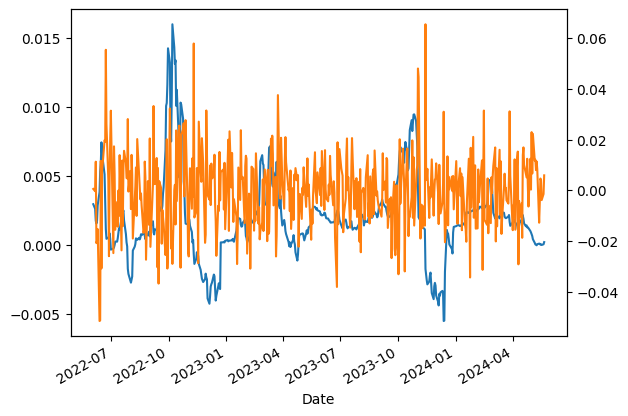

In [143]:
predicted_y.plot()
rtn.loc[predicted_y.index].plot(secondary_y = True)


<Axes: xlabel='Date'>

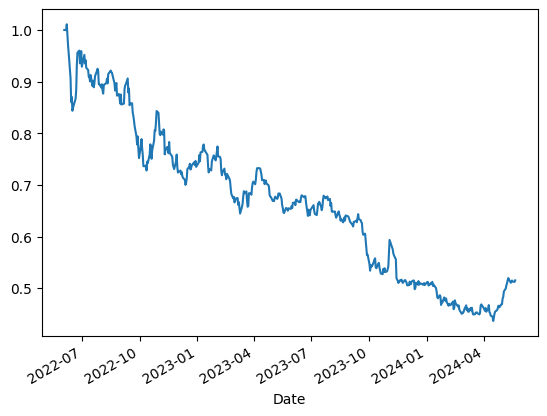

In [144]:
signal = (predicted_y > 0) * 2 - 1
(signal * rtn.loc[signal.index] + 1).cumprod().plot()